In [1]:
%load_ext autoreload
%reload_ext autoreload
from VehicleDetection import VehicleDetection
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from eval_utils import *
from video_utils import *

In [2]:

data_path = './AICity_data/train/S03/c010/'


def noiseBoxes(detections, elems, modBox=True, delBoxes=True, genBoxes=False):
  noiseVals = np.random.normal(0,1,elems)
  random.shuffle(noiseVals)
  i = 0

  newBoxes = {}
  for frame, ds in detections.items():
    newBoxes[frame] = []
    for d in ds:
      if noiseVals[i] < 0.5: #Edit position and size of box
        editBox = np.random.randint(-50, 50, size=(4,))
        dAux = copy.deepcopy(d)
        dAux.xtl += editBox[0]
        dAux.ytl += editBox[1]
        dAux.w += editBox[2]
        dAux.h += editBox[3]
        dAux.xbr = dAux.xtl + dAux.w
        dAux.ybr = dAux.ytl + dAux.h
        newBoxes[frame].append(dAux)
      elif noiseVals[i] > 0.85: #Do nothing
        newBoxes[frame].append(copy.deepcopy(d))
      #between 0.5 and 0.85 delete box
      i += 1
  
  return newBoxes


def readDetections(path):
  with open(path) as f:
    lines = f.readlines()

  detections = {}
  for line in lines:
    data = line.split(',')
    if data[0] in detections:
      detections[data[0]].append(VehicleDetection(int(data[0]), int(data[1]), float(data[2]), float(data[3]), float(data[4]), float(data[5]), float(data[6])))
    else:
      detections[data[0]] = [VehicleDetection(int(data[0]), int(data[1]), float(data[2]), float(data[3]), float(data[4]), float(data[5]), float(data[6]))]


  return detections

In [3]:
gt_detect = readDetections(data_path + 'gt/gt.txt')
key0 = list(gt_detect.keys())[0]
for detec in gt_detect[key0]:
  auxIou = detec.IoU(detec)
  if auxIou > 1.0:
    print(f'Intersection over union for GT boxes: {auxIou}')


In [3]:
gtNoised = noiseBoxes(gt_detect, 2000)

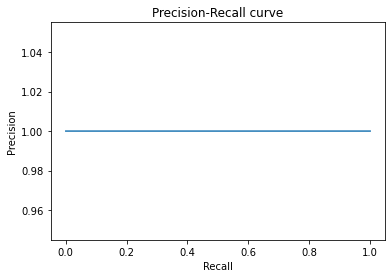

In [4]:
#prefect solution for GT example
rec, prec, ap, tp_GT = voc_eval(gt_detect, gt_detect, 0.5, True)

plot_prec_recall_curve(prec, rec)

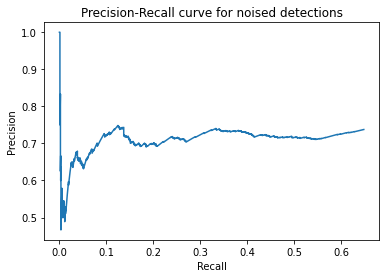

In [5]:
#solution for noisy GT example
rec, prec, ap, tp_Noise = voc_eval(gt_detect, gtNoised, 0.5, True)

plot_prec_recall_curve(prec, rec, 'Precision-Recall curve for noised detections')

In [4]:
yolo3_dect = readDetections(data_path + 'det/det_yolo3.txt')

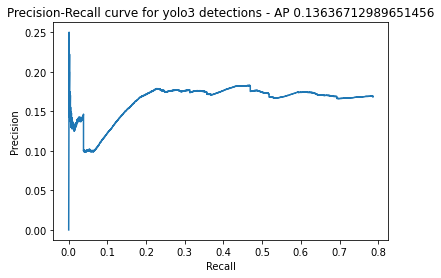

In [13]:
rec, prec, ap, tp_yolo3 = voc_eval(gt_detect, yolo3_dect, 0.5, False)

plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for yolo3 detections - AP {ap}')

In [5]:
ssd512_dect = readDetections(data_path + 'det/det_ssd512.txt')

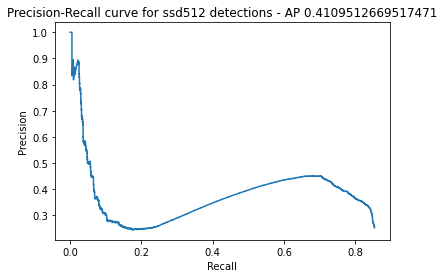

In [18]:
rec, prec, ap, tp_SSD512 = voc_eval(gt_detect, ssd512_dect, 0.5, True)

plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for ssd512 detections - AP {ap}')

Average precision 0.15866257691265073


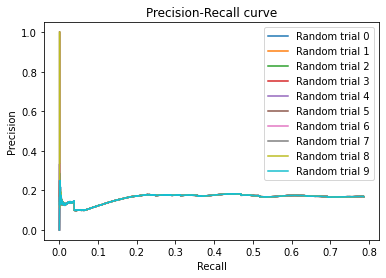

In [8]:
#Multiple random shuffle of predictions for cases without confidence
N = 10
recs, precs, aps = ap_wo_conf(gt_detect, yolo3_dect, N, 0.5)
print(f'Average precision {np.mean(aps)}')
labels = [('Random trial ' + str(i)) for i in range(N)]
plot_multiple_prec_recall_curves(precs, recs, labels)

In [ ]:
generate_videoBB(data_path + 'vdo.avi', gt_detect, 'GT_boundingBoxes')

In [7]:
generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, tp_yolo3, 'yolo3_boundingBoxes', 200, 1000)

100%|██████████| 82/82 [00:00<00:00, 90.65it/s]
